In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import auc, roc_curve, RocCurveDisplay

In [57]:
def plot_roc_curve(y_true, y_score, classes):

    n_classes = len(classes)

    label_binarizer = LabelBinarizer(sparse_output=False)
    label_binarizer.fit(classes)

    global y_onehot, y_temp
    y_temp = label_binarizer.fit_transform(classes)
    y_onehot = label_binarizer.transform(y_true)
    
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    fpr_grid = np.linspace(0.0, 1.0, 1000)
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    fig, ax = plt.subplots(figsize=(25, 8))

    plt.plot(fpr["macro"], tpr["macro"], label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})", color="navy", linestyle=":", linewidth=4)

    colors = cycle(plt.cm.tab10(np.linspace(0, 1, n_classes)))
    for i, color in zip(range(1, n_classes), colors):
        RocCurveDisplay.from_predictions(y_onehot[:, i], y_score[:, i], name=f"ROC curve for class {i}", color=color, ax=ax, plot_chance_level=(i == 1))

    plt.legend(loc='best', fontsize='small')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-class ROC curve")
    plt.show()

In [58]:
# Load the results CSV file
results_df = pd.read_csv("results.csv")

models_to_test = ["spkrec-ecapa-voxceleb", "spkrec-xvect-voxceleb", "spkrec-resnet-voxceleb"]
model_colors = {"spkrec-ecapa-voxceleb": ("#2265BD", "Blues"), "spkrec-xvect-voxceleb": ("orange", "Oranges"), "spkrec-resnet-voxceleb": ("#63A93A", "Greens")}

In [59]:
# from results_df, build a df with the model, the name_to_verify, the prediction and the probas

df_roc = results_df.drop(columns=['audio_reference', 'time'])
# group by model and name_to_verify, list all the predictions and probas
df_roc = df_roc.groupby(['model', 'audio_to_verify']).agg(list).reset_index()
# for name to verify, keep first index of the list
df_roc['name_to_verify'] = df_roc['name_to_verify'].apply(lambda x: x[0])
# add prediction column. If result is False, prediction is "Unknown", else prediction is the name_reference[index max of probas]
df_roc['prediction'] = df_roc.apply(lambda x: x['name_reference'][x['proba'].index(max(x['proba']))] if x['result'][x['proba'].index(max(x['proba']))] else "Unknown", axis=1)
# append 1 or 0 at each proba list depending on any(true) in result

classes ['Unknown', 'alex_pereira_ferreira', 'beatriz_rojas_romero', 'benoit_froge', 'clement_lidar', 'eliot_christon', 'florent_bissonnier', 'hadrien_genuer', 'ines_delplanque', 'ingrid_floriet', 'nahel_verdier', 'neill_vanmoc', 'raphael_maarek', 'tatyana_budueva', 'thomas_oxisoglou']


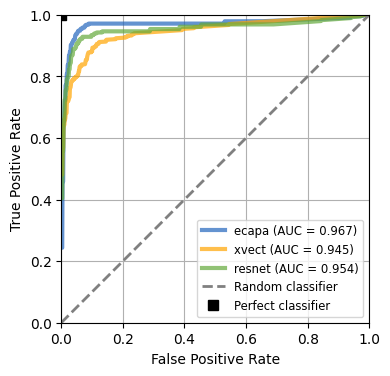

In [101]:
classes = ["Unknown"] + df_roc['name_reference'].iloc[0]
print("classes", classes)

fig, ax = plt.subplots(figsize=(4, 4))

EER = {}
EER_STD = {}

for model in models_to_test:
    y = df_roc[df_roc['model'] == model]['name_to_verify'].reset_index(drop=True).to_numpy()
    y_pred = df_roc[df_roc['model'] == model]['prediction']
    y_proba = df_roc[df_roc['model'] == model]['proba'].reset_index(drop=True).to_numpy()
    y_proba = np.array([[proba for proba in probas] for probas in y_proba])
    # add 0 if any(result) is True, else add 100
    y_add_proba = df_roc[df_roc['model'] == model]['result'].apply(lambda x: 0 if any(x) else 100).to_numpy()
    y_proba = np.concatenate((y_add_proba.reshape(-1, 1), y_proba), axis=1)
    y_score = np.array([[proba for proba in probas] for probas in y_proba])
    def normalize(probas):
        """Normalize the probas, make sure positive and between 0 and 1"""
        res = np.array(probas)
        min_proba = np.min(res, axis=0)
        sum_proba = np.sum(res, axis=0)
        res = (res - min_proba) / sum_proba
        return res
    y_score = np.array([normalize(probas) for probas in y_score])

    n_classes = len(classes)

    label_binarizer = LabelBinarizer(sparse_output=False)
    label_binarizer.fit(classes)

    y_temp = label_binarizer.fit_transform(classes)
    y_onehot = label_binarizer.transform(y)
    
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    fpr_grid = np.linspace(0.0, 1.0, 1000)
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    EER[model] = fpr["macro"][np.nanargmin(np.abs(tpr["macro"] - (1 - fpr["macro"])))]

    model_str = model.replace("spkrec-", "").replace("-voxceleb", "")
    plt.plot(fpr["macro"], tpr["macro"], color=model_colors[model][0], linestyle="-", alpha=0.7, linewidth=3, label=f"{model_str} (AUC = {roc_auc['macro']:.3f})")

# random
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', linewidth=2, label="Random classifier")

# perfect
plt.plot([0], [1], marker='s', markersize=7, color="black", label="Perfect classifier", linestyle='None')

# make the plot square
plt.gca().set_aspect('equal', adjustable='box')
# limits
plt.xlim([0, 1])
plt.ylim([0, 1])
# grid
plt.grid(True)
# legend
plt.legend(loc='best', fontsize='small')
# labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("Multi-class macro-average ROC curves")
plt.savefig("plots/roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()

In [103]:
print(EER)

{'spkrec-ecapa-voxceleb': 0.05405405405405406, 'spkrec-xvect-voxceleb': 0.10710710710710711, 'spkrec-resnet-voxceleb': 0.07207207207207207}


In [22]:
from sklearn.metrics import confusion_matrix

for model in models_to_test:
    print(f"Model: {model}")
    y = df_roc[df_roc['model'] == model]['name_to_verify']
    y_pred = df_roc[df_roc['model'] == model]['prediction']
    cm = confusion_matrix(y, y_pred, labels=classes)
    print(cm)
    print("accuracy", np.trace(cm) / np.sum(cm))
    

Model: spkrec-ecapa-voxceleb
[[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 17  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0 40  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 22  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0 21  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  1  0 18  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 23  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 19  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 14  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 13  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 24  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0 22  0]
 [ 1  1  0  1  0  0  0  0  0  0  0  1  0  0  5]]

Model: spkrec-xvect-voxceleb
[[19  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 10  6  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  0 40  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2 17  0  0  0  0